In [1]:
!pip install kaggle

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import os

api = KaggleApi()
api.authenticate()

for file in ['train.tsv', 'test.tsv']:
    api.competition_download_file('sentiment-analysis-on-movie-reviews', f'{file}.zip', path='./')

    with zipfile.ZipFile(f'{file}.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

    os.remove(f'{file}.zip')

100%|██████████| 1.28M/1.28M [00:00<00:00, 10.6MB/s]

100%|██████████| 494k/494k [00:00<00:00, 9.65MB/s]

# Prepare the Data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
df = df.drop_duplicates(subset=['SentenceId'], keep='first')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


<AxesSubplot:>

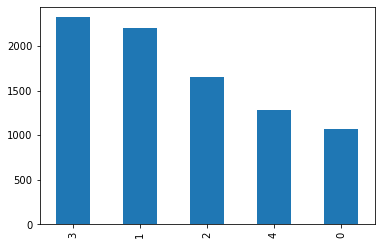

In [6]:
df['Sentiment'].value_counts().plot(kind='bar')

## Tokenizing 

Create two input tensors: *input IDs* and *attention mask*
* 512 = `BERT` embeddings dimension

In [11]:
import numpy as np

seq_len = 512
num_samples = len(df)

num_samples, seq_len

(8529, 512)

### Tokenize the reviews

### Get the labels (sentiments)

In [53]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokens = tokenizer(df['Phrase'].tolist(),
                    max_length=seq_len,
                    truncation=True,
                    padding='max_length',
                    add_special_tokens=True,
                    return_tensors='pt')

In [54]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [60]:
input_ids = tokens['input_ids']
input_ids.shape

torch.Size([8529, 512])

In [65]:
attention_mask = tokens['attention_mask']
attention_mask.shape

torch.Size([8529, 512])

In [46]:
import torch
import torch.nn.functional as F
arr = df['Sentiment'].values
labels = torch.zeros((num_samples, arr.max()+1))
labels[:5]
arr[:5]

array([1, 4, 1, 3, 1])

In [48]:
for i in range(len(arr)):
    labels[i, arr[i]] = 1
labels[:5]

tensor([[0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.]])

In [64]:
print(f"The shape of tokenized phrases: {input_ids.shape}")
print(f"The shape of labels: {labels.shape}")

The shape of tokenized phrases: torch.Size([8529, 512])
The shape of labels: torch.Size([8529, 5])


In [66]:
torch.save(input_ids, 'phrases.pt')
torch.save(attention_mask, 'attention_mask.pt')
torch.save(labels, 'labels.pt')